In [1]:
from src.EDA import FaceDatasetAnalyzer
from src import config

Classes detected:
  - asian_females
  - asian_males
  - black_females
  - black_males
  - indian_females
  - indian_males
  - white_females
  - white_males

Class distribution:
asian_females: 2500
asian_males: 2500
black_females: 2500
black_males: 2500
indian_females: 2500
indian_males: 2500
white_females: 2500
white_males: 2500

Sampled 500 images for dimension analysis.
Average width: 107.8
Average height: 123.9


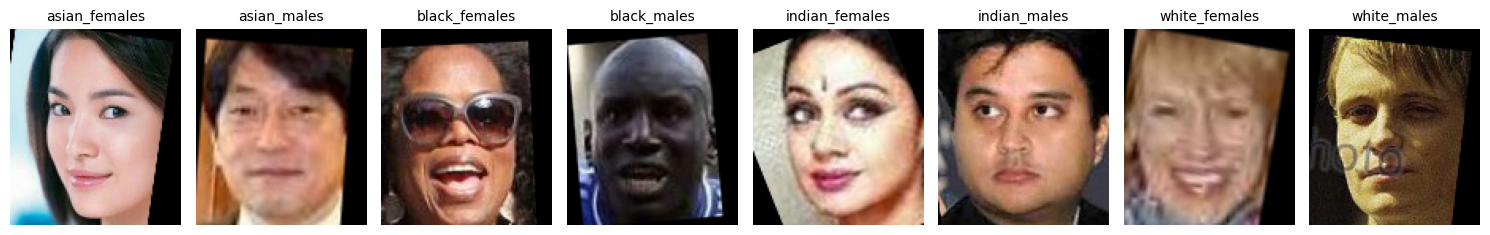

Computing mean faces: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


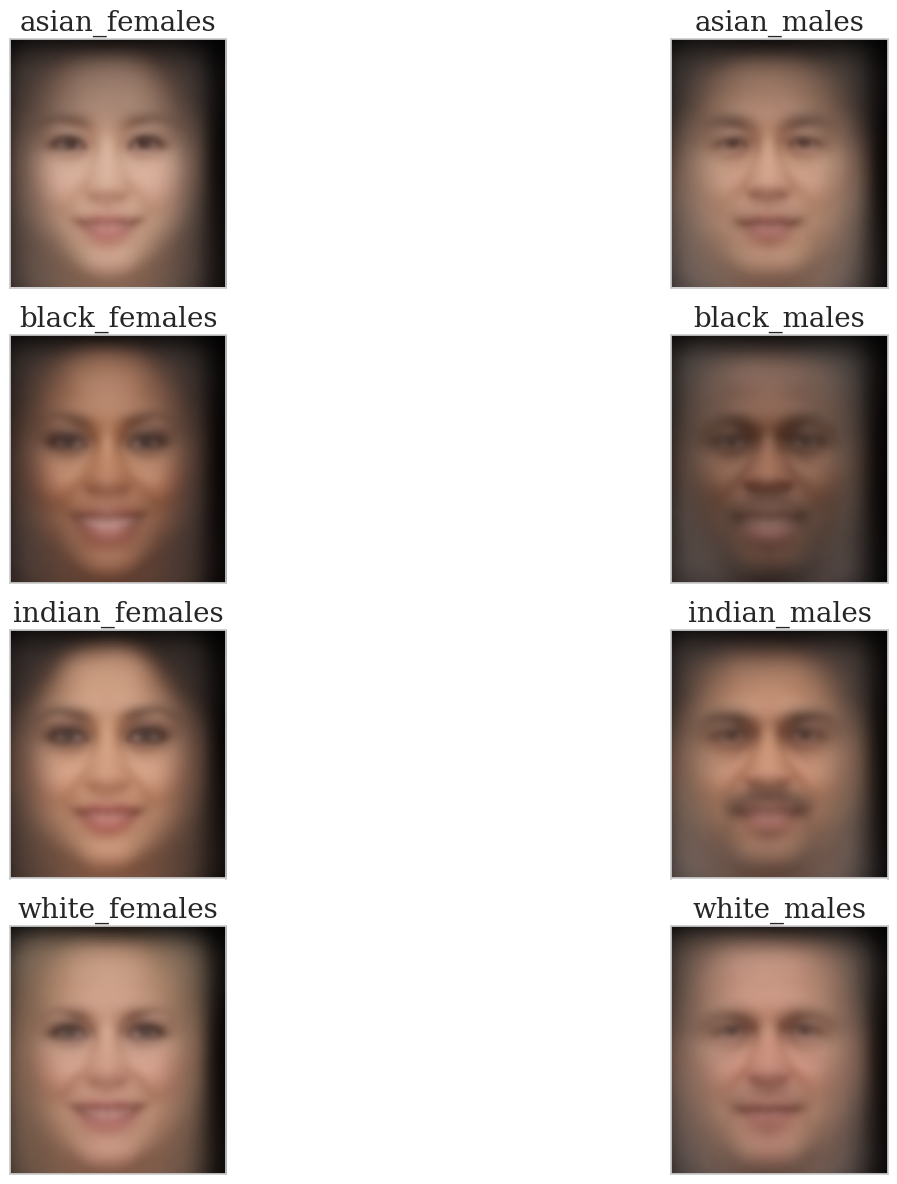

[array([[[0.04234633, 0.0368397 , 0.03668607],
         [0.04406171, 0.03836453, 0.03780364],
         [0.04694641, 0.04063319, 0.03990502],
         ...,
         [0.01480951, 0.01251964, 0.01231189],
         [0.0138348 , 0.01160839, 0.01156534],
         [0.01309172, 0.01082103, 0.01077042]],
 
        [[0.04713943, 0.04143549, 0.04057959],
         [0.04893849, 0.04305149, 0.04173973],
         [0.0531593 , 0.04655541, 0.04515948],
         ...,
         [0.01653004, 0.01424578, 0.0139087 ],
         [0.01537345, 0.01313306, 0.01289548],
         [0.01430863, 0.01203868, 0.01183158]],
 
        [[0.05460624, 0.04821336, 0.04697866],
         [0.05685142, 0.05012482, 0.04845243],
         [0.06198005, 0.05445703, 0.05269836],
         ...,
         [0.01833767, 0.01595481, 0.01552372],
         [0.01664415, 0.01431891, 0.01399428],
         [0.01527617, 0.01290634, 0.01264164]],
 
        ...,
 
        [[0.22883984, 0.19043134, 0.17443298],
         [0.24462602, 0.20432176, 0.18736

In [2]:
DATA_DIR = config.DATA_DIR

# Or step-by-step
analyzer = FaceDatasetAnalyzer(DATA_DIR)
analyzer.print_classes()
analyzer.print_class_distribution()
analyzer.print_dimension_stats()
analyzer.plot_sample_images()
analyzer.plot_mean_faces()